# Forward modelling of proxy timeseries
In this Tutorial 2, we will apply operators in space and time to model simulation data (`sim_data`). As a result, we will obtain forward-modeled proxy time series for selected proxy datasets. Please make sure you are familiar with the contents of Example 1 "Getting Started".

## 0. Preparations

In this tutorial, we will again work with real scientific data. We will use climate model output of transient simulation of the last deglaciation. The simulation was performed with MPI-ESM-CR-1.2 and used the GLAC1D ice sheet reconstruction as boundary conditions. See the [publication](https://doi.org/10.1029/2021GL096767) for more details. For downloading the netcdf files, use the [wget script](https://github.com/paleovar/cupsm/blob/main/data/wget-mpiesm_simulations_20231208135007.sh) we provided or check out the download possibilities in the dataset [description](https://www.wdc-climate.de/ui/entry?acronym=PMMXMCRTDGP132).

In our example, we will use the simulated sea surface temperature (variable `tos`) over 25000 simulated years. Naturally, the variable comes on an unstructured grid and must be regridded. We recommend regridding with the `xesmf` package. We prepared some code for it in the `utilities_sst_example.py` file. To use it, please add the absolute file path to one of your example files in line 27 in the `utilities_sst_example.py` file. Then run the provided piece of code in a notebook (copy code into cells):

```python
%run utilities_sst_example.py
```

Then, you can define a regridder and print its properties:

```python
regridder = get_regridder()

print(regrider)
```

We then regridded in a simple for-loop (change the paths to suit your directory structure):

```python
path_deglac='/path/to/your/downloaded/data'
target_path = '/path/to/your/regridded/data'

file_list = [f for f in os.listdir(path_deglac) if f.endswith(".nc")]

for i, file in enumerate(file_list):
    # counter
    if not i % 10: 
        print(f"Interpolating file {i}/{len(file_list)}")
    f = xr.open_dataset(path_deglac+file)
    f_r = regridder(f, skipna=True, na_thres=0.5).tos.to_dataset()
    f_r.attrs["Interpolation"] = "Periodic bilinear interpolation by xESMF Regridder, skipna=True, na_thres=0.5"
    f_r.to_netcdf(target_path+"r_"+file)

```

Now let `xesmf` do its magic. Take a break, grab a coffee or tea. For us, the regridding took about 10 minutes.

As in the first tutorial, the data paths must be defined. You can reuse your `lipd_path` and `table_path` unless you want to use a different proxy database. The `sim_data_path` is the directory where the regridded netcdf files are.

In [1]:
lipd_path = "/data/obs/proxy_databases/PalMod130k/PALMOD130k_v1_0_1_250320/LiPD/" # path to directory where LiPD files are (only necessary if recreated)
table_path = "/data/projects/nfdi4earth/" # path where the overview table should be stored
sim_data_path = "/data/projects/nfdi4earth/regridded_tos_mpi-esm/" # path where the regridded netcdf files of the simulation data are

Finally, import the required packages.

In [2]:
# import packages
import pandas as pd
import numpy as np
import xarray as xr

# import cupsm
# since cupsm is only available on GitHub, 
# you need to expand your python path variable 
# to the code directory for this notbook session
import sys
sys.path.append('../') # here, it will be the parent direcory
import cupsm
# import a function from the tutorial code bits
from tutorials.utilities_sst_example import transfer_timeaxis_deglac, plot_results

# import plotting packages
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [3]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

## 1. Initialize obs_data
**as dictionary, keys are the site names and values the site_objects**


Here, we reuse the code of the Tutorial 1.

In [4]:
# load the overview table
proxy_overview_table = cupsm.create_proxy_info(database_path=lipd_path, save_path=table_path)

# specify example sites
sites = ["SU81_18.lpd", "TR163_22.lpd", "SO201_2_12KL.lpd", "MD98_2181.lpd", "GeoB1711_4.lpd"]

# get the obs_data object
obs_data = cupsm.get_records_df(df=proxy_overview_table, file_name=sites, return_as="dictionary")

The .proxy_meta_data.pkl file is already present in /data/projects/nfdi4earth/ and is returned.
For updating the file, run with the update=True
I return a dictionary with 5 record objects at None +/- None.


## 2. Initialize sim_data
**as chunked xarray DataArray**

Here, we use xarray's `open_mfdataset` function which allows to load multiple files as a single dataset. The keyword `parallel=True` enables parallelized file opening using dask. For us, opening 25000 years of simulation data took about 9 seconds. 

In [5]:
sim_data = xr.open_mfdataset(f"{sim_data_path}*.nc", parallel=True, use_cftime=True,)

sim_data

<xarray.Dataset>
Dimensions:  (time: 300000, lat: 101, lon: 122)
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 25000-12-16 12:00:00
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
Data variables:
    tos      (time, lat, lon) float64 dask.array<chunksize=(1200, 101, 122), meta=np.ndarray>
Attributes:
    Interpolation:  Periodic bilinear interpolation by xESMF Regridder, skipn...

Our sim_data contains the variable `tos` on monthly resolution (300000 time steps) and the time axis goes from January in year 0001 to December in year 25000. In the imports, a function `transfer_timeaxis_deglac` is imported from the `utilities_sst_example.py`. This transfers the time axis of the simulation data. Now, it covers the timespan of 25 kiloyears before present to 0 kiloyears before present and is therefore in tune with the time axis of the proxy database. 

**NOTE:** This is not a general function but very specific to our example. If you use your own model output, make sure that the time axis is correctly defined and contains `cftime.Datetime` objects.

In [6]:
# apply the time axis transformation and chose our variable `tos`
sim_data = transfer_timeaxis_deglac(sim_data.tos)

Now, since we chose the variable, we now have a chunked xarray DataArray named `tos`:

In [7]:
sim_data

<xarray.DataArray 'tos' (time: 300000, lat: 101, lon: 122)>
dask.array<concatenate, shape=(300000, 101, 122), dtype=float64, chunksize=(1200, 101, 122), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
  * time     (time) object 25000-01-16 12:00:00 ... 0001-12-16 12:00:00

## 3. Initialize target object
**as dictionary of python class objects, keys are the site_names**

If you have already worked with proxy data, you'll know that it's all about the details! To define target objects for the chosen obs_data, we need to know more about our proxies.

Let's load the proxy data and hava a look at the available datasets.

In [8]:
# load the data, quiet=True suppresses diagnostic print outs and save_in_object saves the xarray
# DataSet in the data attribute: site_object.data

for i,site_object in enumerate(obs_data.values()):
    site_object.load_paleo_data("all", save_in_object=True, quiet=True)

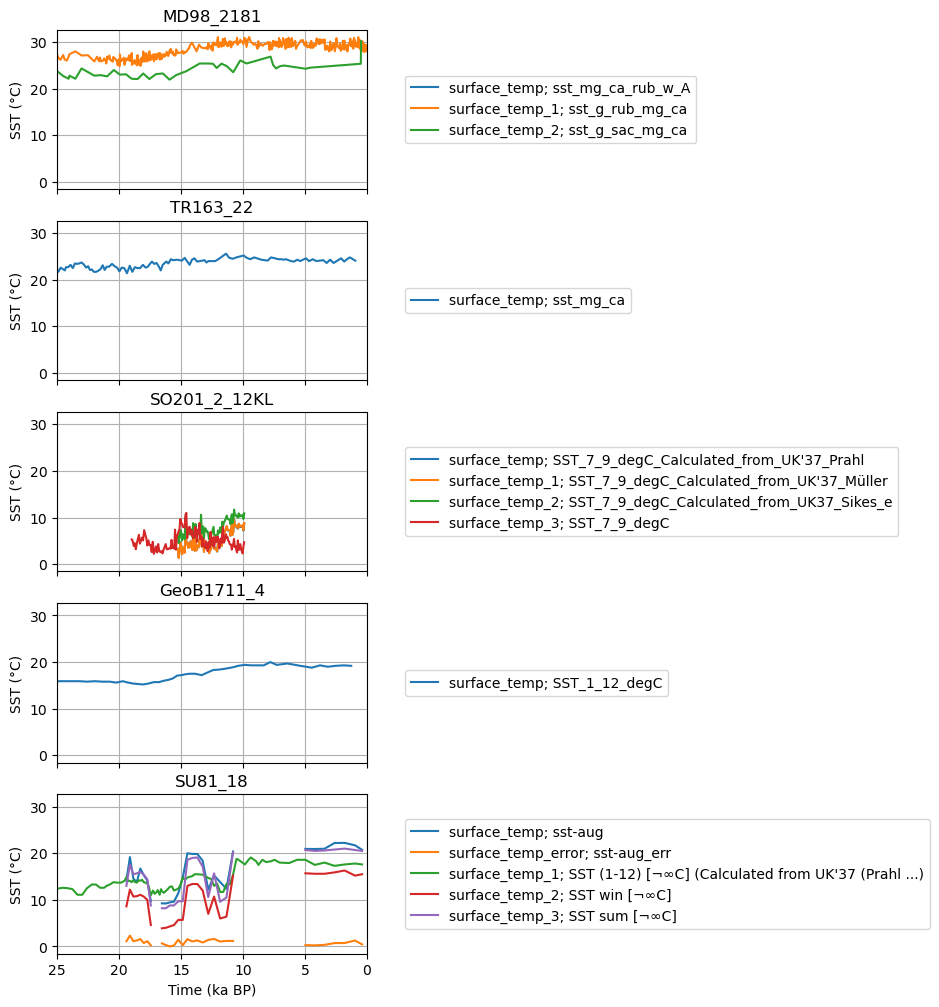

In [9]:
# plot temperature data for the five sites
fig, axes = plt.subplots(5,1, figsize=(4,12), sharex=True, sharey=True)
axes = axes.flatten()

# iterate through site_objects, one plot for one object
for i,site_object in enumerate(obs_data.values()):
    a = axes[i]
    a.set_title(site_object.site_name)
    
    # create a list of available variables with the keyword "temp" in them
    temp_variables = [var for var in site_object.data.variables if "temp" in var]

    # iterate through available variables
    for var in temp_variables:
        mask = ~np.isnan(site_object.data[var])
        a.plot(site_object.data.age[mask], site_object.data[var][mask], label=f"{var}; {site_object.data[var].description}")
    a.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    a.grid()
    a.set_xlim(25,0)
    a.set_ylabel("SST (°C)")

axes[-1].set_xlabel("Time (ka BP)")
plt.show()

There are indeed some details to explore! For three of the five records, there are multiple datasets of palaeotemperature measurements. Now we have to make some subjective choices: For these records, we have to decide which temperature time series we want to use, since some of them are summer or winter temperatures, for example. To do this we will use two dictionaries where each site name is assigned a variable name and a habitat season. This information is used to create a class object that is a subclass of the `site_object` - the `target` using the `create_target()` method. Once created, the `target` is available via `site_object.target`. 

The target object creator accepts following keywords:
- `record_var`:     string; the variable name of the paleo dataset
- `sim_var`:        string; the variable name of the simulation dataset
- `habitatSeason`:  string or list of integers; 
    - string; valid keywords are "summer", "winter" or "annual". Refers to the local season (e.g. austral summer is summer).
    - list of integers; indices of the month for which the paleo data are representative (for example, for boreal summer temperatures, month_i could be [7,8,9] for samples taken in July, August and September).

In [10]:
# dictionaries for subjective choices

mapping_vars = {"MD98_2181": "surface_temp_1", # orange line
                "TR163_22": "surface_temp", # blue line
                "SO201_2_12KL": "surface_temp_3", # red line
                "GeoB1711_4": "surface_temp", # blue line
                "SU81_18": "surface_temp_1", # green line
               }

mapping_season = {"MD98_2181": "annual", # assume annual, since no further information available
                "TR163_22": "annual", # assume annual, since no further information available
                "SO201_2_12KL": [7,8,9], # put 7,8,9 as list of integers, since month 7-9 are given in description
                "GeoB1711_4": "annual", # assume annual, since month 1-12 are given
                "SU81_18": "annual",  # assume annual, since month 1-12 are given
               }

In [11]:
# initialize target objects in a for loop

for i,site_object in enumerate(obs_data.values()):
    
    # set variable names and season
    record_variable = mapping_vars[site_object.site_name]
    simulation_variable = "tos"
    habitat_season = mapping_season[site_object.site_name]
    
    # intializes target object
    site_object.create_target(record_var=record_variable, sim_var=simulation_variable, habitatSeason=habitat_season)


In [12]:
# Now one can access the target via the site_object:
import random # import random 

example_site = random.choice(sites).rstrip(".lpd") # chose a random site from our list

if obs_data[example_site].target.habitatSeason is None:
    print(f"For site {example_site}, the habitat season are the month {obs_data[example_site].target.month_i}.")
else:
    print(f"For site {example_site}, the habitat season is {obs_data[example_site].target.habitatSeason}.")



For site TR163_22, the habitat season is annual.


## 4. Apply operators
Currently there are three types of operators implemented: 
- Space operators (`field2site`) that map the spatial fields of the `sim_data` onto the spatial structure of the `site_objects`.
- Chronology operators (`time2chron`) that map data from the regular `sim_data` time axis to the irregular `site_object` time axis.
- Variable operators that transform the data in `sim_data` to mimic uncertainties from the proxy-climate relationship and archival processes (see Tutorial 3).

First, we will explore the space and chronology operators for a shorter section of the `sim_data` and finally apply both operators in a parallelized for-loop for the `obs_data` object and the full length of the `sim_data`.

In [13]:
# define an examle site_object

example_site_object = obs_data[example_site]

In [14]:
# define a shorter section (500 years from 16 ka to 15.5 ka)

example_sim_data = sim_data.where(sim_data['time.year'].isin(np.arange(16000,15000,-1)), drop=True)
example_sim_data

<xarray.DataArray 'tos' (time: 12000, lat: 101, lon: 122)>
dask.array<where, shape=(12000, 101, 122), dtype=float64, chunksize=(1200, 101, 122), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
  * time     (time) object 16000-01-16 12:00:00 ... 15001-12-16 12:00:00

### 4.1 Space operator
When applying the space operator, you can choose between two interpolation methods:
- `nn`: nearest grid cell which is not nan
- `dist`: distance weighted mean over grid cells which are within radius (default: 500 km)

The radius for the method `dist` can be set by the `radius_km` keyword.

For diagnostic purposes, one can do a simple plot of the mask, which is used for interpolation (`plot_mask=True`).

Here are some tests:

CPU times: user 3.97 s, sys: 2.14 s, total: 6.12 s
Wall time: 11.9 s


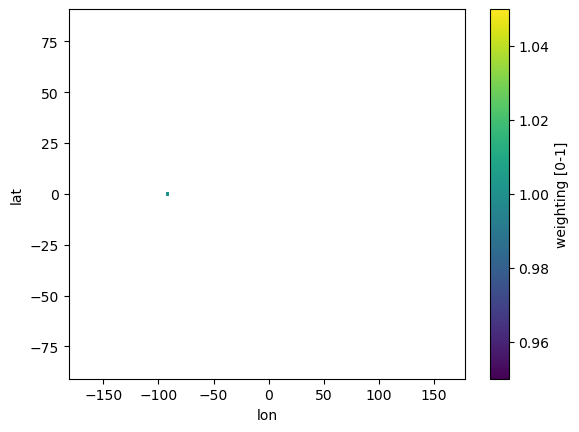

In [15]:
%%time
# test nn method

_ = cupsm.field2site(example_sim_data, example_site_object, method="nn", plot_mask=True)

CPU times: user 1.84 s, sys: 966 ms, total: 2.81 s
Wall time: 674 ms


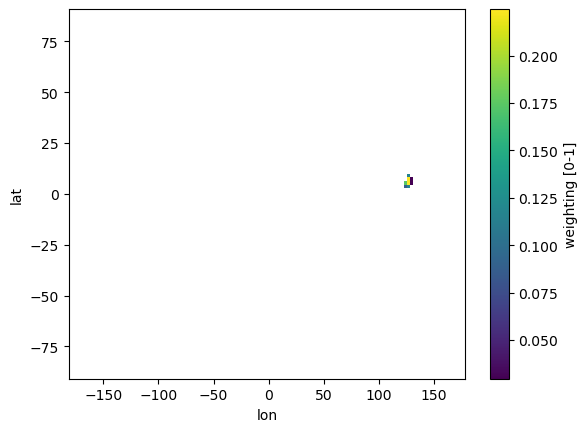

In [16]:
%%time
# test dist method

_ = cupsm.field2site(example_sim_data, example_site_object, plot_mask=True)

In [17]:
print(f"Our example site object is located at lon={example_site_object.coords[0]} and lat={example_site_object.coords[1]}.")

Our example site object is located at lon=125.8274 and lat=6.3.


The maps used for interpolation have naturally the highest values at the site location. For `nn`, the nearest grid cell (only one) is taken. For `nn`, the number of grid cells which are used for interpolation depend on the `radius_km` keyword.

If you want to see how the mask behaves for different radii, try this code snippet:

```python
for radius in [300,500,1000,2000]:
    print(f"For a radius of {radius} km, the interpolation mask looks like that:")
    cupsm.field2site(example_sim_data, example_site_object, radius_km=radius, plot_mask=True)
    plt.show()
```

The space operator works on chunked data. The chronology operator **does not work well** on chunked data, so we need to compute our object at this point.

In [18]:
%%time

example_sim_data2site = cupsm.field2site(example_sim_data, example_site_object).compute()

CPU times: user 2.25 s, sys: 1.55 s, total: 3.8 s
Wall time: 959 ms


### 4.2 Chronologies operator
When applying the chronologies operator, you can choose between two methods for mapping the data from the regular sim_data time axis onto the irregular site_object time axis:
- `point2point`: point to point mapping 
- `slice2point`: slice to point mapping; assumes time slices in the sim_data time axis that are representative of the measured sample, these are mapped to points in the chronologies. 

For `slice2point`, there are two sampling methods available, `adjacent` and `distant`. The following graphic explains how the different mappings work.

<img src="chron_operators_illustration.png" width="600">

In [27]:
%%time

# using point2point (default)
example_fwd_p2p = cupsm.time2chron(sim_data2site=example_sim_data2site, site_object=example_site_object)

CPU times: user 1.44 s, sys: 2.03 ms, total: 1.44 s
Wall time: 1.44 s


In [24]:
%%time

# using point2point, adjacent
example_fwd_s2p_a = cupsm.time2chron(sim_data2site=example_sim_data2site, site_object=example_site_object,
                                    method="slice2point", sampling="adjacent")

CPU times: user 15.8 s, sys: 55.4 ms, total: 15.9 s
Wall time: 15.8 s


In [26]:
%%time

# using point2point, distant
example_fwd_s2p_d = cupsm.time2chron(sim_data2site=example_sim_data2site, site_object=example_site_object,
                                    method="slice2point", sampling="distant")

A default sampling size of 10 millimeter is used.
CPU times: user 19.2 s, sys: 16.5 ms, total: 19.2 s
Wall time: 19.2 s


The `point2point` mapping is much faster than the `slice2point` mapping. However, it is recommended to use the `slice2point` method, since it should be more comparable to the way the samples were extracted (adjust the `sampling_size` keyword accordingly).

Let's have a look at the forward-modeled proxy time series:

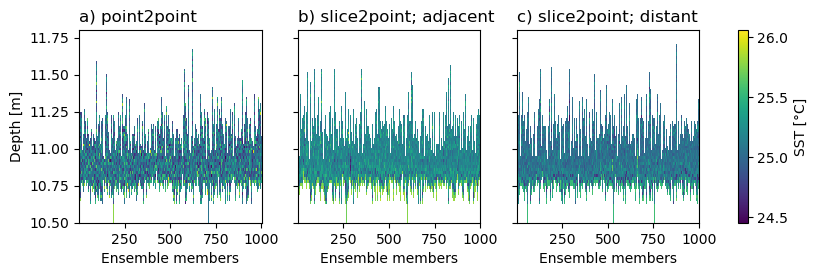

In [60]:
titles = ["a) point2point", "b) slice2point; adjacent", "c) slice2point; distant",]
data = [example_fwd_p2p, example_fwd_s2p_a, example_fwd_s2p_d,]
#----
fig, axs = plt.subplots(1,3, figsize=(10,2.5), sharex=True, sharey=True)
axes = axs.flatten()

for i,a in enumerate(axes):
    a.set_title(titles[i], loc="left")
    ds = data [i]
    im = a.pcolormesh(ds.ens, ds.depth, ds, cmap="viridis")
    a.set(xlabel="Ensemble members")

axes[0].set_ylabel("Depth [m]")

plt.colorbar(im, ax=axs[:], label="SST [°C]", orientation="vertical")

plt.show()

For each member of the chronology ensemble, the simulation data is sampled according to the time axis mapping. If we had used a longer time slice in our example, instead of just 1000 years, we would have more data in the forward-modeled proxy time series. The spread among the ensemble members reflects the uncertainty in the age model.

For the `slice2point` sampling method, the time series are smoother, since more datapoints have been averaged. For the default `sampling_size=10`, the `adjacent` method introduces the strongest smoothing.

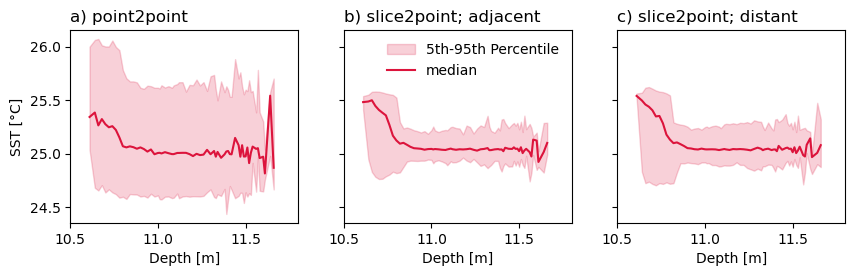

In [100]:
fig, axs = plt.subplots(1,3, figsize=(10,2.5), sharex=True, sharey=True)
axes = axs.flatten()

for i,a in enumerate(axes):
    a.set_title(titles[i], loc="left")
    ds = data [i]

    # create mask, that at least 5 ensemble members contain data
    mask = ((~ np.isnan(ds)).sum("ens") >= 5)
    depth_masked = ds.depth[mask]
    
    percentile_5th = np.nanpercentile(ds, 5, axis=1)[mask]
    percentile_95th = np.nanpercentile(ds, 95, axis=1)[mask]

    a.fill_between(depth_masked, percentile_5th, percentile_95th, color="crimson", alpha=0.2, label="5th-95th percentile")
    a.plot(depth_masked, ds.median("ens")[mask], color="crimson", label="median")
    

    a.set(xlabel="Depth [m]")

axes[0].set_ylabel("SST [°C]")
axes[1].legend(frameon=False)

plt.show()

This plot shows the forward-modeled proxy time series of SST versus depth in terms of the ensemble median and the 5th to 95th percentile range of the ensemble. Consistent with the upper plot, the range of the ensemble is reduced for the `slice2point` method because it introduces more smoothing.

## 4.3 Apply operators for obs_data
Here, we will apply both operators sequentially in a parallelized for loop for our five example sites.

To parallize the loop, we will make use of the [`dask`](https://docs.dask.org/en/stable/) package. If you want to read more about parallelized for loops in dask, check out dask's [tutorial](https://tutorial.dask.org/03_dask.delayed.html) on it!


In [101]:
import dask

In [ ]:
# start a client, to your needs
# the machine on which this example was produced has 16 cores --> n_workers=16

from dask.distributed import Client
client = Client(n_workers=16)
client

In [108]:
# wrapper function which will be used in parallel
@dask.delayed(nout=2)
def apply_operators(sim_data, site_object):
    # apply space operator
    sim_data2site = cupsm.field2site(sim_data, site_object, radius_km=300).compute()
    print(site_object.site_name, " space operator done")
    # apply chron operators
    forward_model, resampled_simdata = cupsm.time2chron(sim_data2site=sim_data2site, site_object=site_object,
                                                        method="slice2point", sampling="distant", return_resampled=True, quiet=True) 
    print(site_object.site_name, " resampling done")
    return forward_model, resampled_simdata

In [121]:
%%time

# initalize forward_obs_data as dictionary
forward_obs_data = {}
resampled_sim_data = {}

# compute in a parallelized for loop
for i,site_object in enumerate(obs_data.values()):
    forward_obs_data[site_object.site_name], resampled_sim_data[site_object.site_name] = apply_operators(sim_data, site_object)

CPU times: user 48.5 ms, sys: 2.93 ms, total: 51.4 ms
Wall time: 48.4 ms


Now the calculations are done lazily (that's why it was so fast), and the results are delayed objects. A delayed object contains everything needed to compute the final result, including references to all the necessary functions, their inputs, and their relationship to each other.

In [123]:
# What is in forward_obs_data?
forward_obs_data

{'MD98_2181': Delayed('getitem-4165839ca9d84df51b96772d292e358e'),
 'TR163_22': Delayed('getitem-b3583445628ca5a43410c18b7b48f930'),
 'SO201_2_12KL': Delayed('getitem-f913a9510ddfa954469001e44763d302'),
 'GeoB1711_4': Delayed('getitem-a943ee97dc34c51360058d4708458488'),
 'SU81_18': Delayed('getitem-7e34443d3b46e0faff727f15145809bd')}

Let's compute the results. This will take much longer - grab a drink and take some time for something else :) On our machine, it took XX minutes to do the computations. If you want to skip this step, you can also simply load our pickle files with the results (see below).

In [125]:
%%time

dask.compute(forward_obs_data)

/home/mracky/miniconda3/envs/condasky_p311/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 50.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


MemoryError: Task 'finalize-70bf7df2-94f7-458c-ac46-27bb1fdaa542' has 27.54 GiB worth of input dependencies, but worker tcp://127.0.0.1:38851 has memory_limit set to 3.90 GiB. It seems like you called client.compute() on a huge collection. Consider writing to distributed storage or slicing/reducing first.

In [ ]:
# save as pickle

## 5. Plot results
- egu plot style with 

## Snipptes

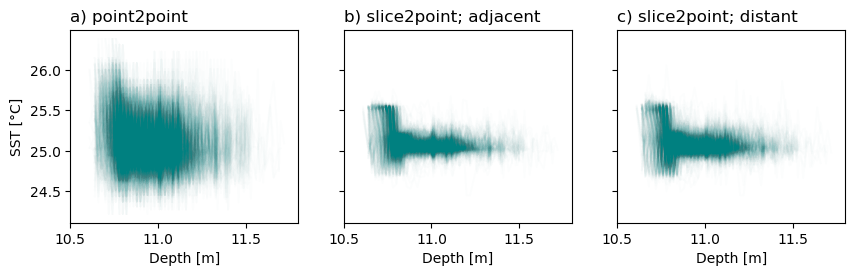

In [68]:
titles = ["a) point2point", "b) slice2point; adjacent", "c) slice2point; distant",]
data = [example_fwd_p2p, example_fwd_s2p_a, example_fwd_s2p_d,]
#----
fig, axs = plt.subplots(1,3, figsize=(10,2.5), sharex=True, sharey=True)
axes = axs.flatten()

for i,a in enumerate(axes):
    a.set_title(titles[i], loc="left")
    ds = data [i]
    for ens_member in ds.T:
        a.plot(ds.depth, ens_member, alpha=0.01, color="teal")
    a.set(xlim = (10.5,11.8), xlabel="Depth [m]")

axes[0].set_ylabel("SST [°C]")

plt.show()

In [83]:
xr.where(ds==np.nan, 0, 1)

<xarray.DataArray 'tos' (depth: 87, ens: 1000)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * depth    (depth) float64 9.37 9.41 9.43 9.47 9.49 ... 11.68 11.69 11.7 11.72
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000

In [89]:
(~ np.isnan(ds)).sum("ens") >= 5

<xarray.DataArray 'tos' (depth: 87)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False])
Coordinates:
  * depth    (depth) float64 9.37 9.41 9.43 9.47 9.49 ... 11.68 11.69 11.7 11.72

## DEbugging at its best


In [1]:
lipd_path = "/data/obs/proxy_databases/PalMod130k/PALMOD130k_v1_0_1_250320/LiPD/" # path to directory where LiPD files are (only necessary if recreated)
table_path = "/data/projects/nfdi4earth/" # path where the overview table should be stored
sim_data_path = "/data/projects/nfdi4earth/regridded_tos_mpi-esm/" # path where the regridded netcdf files of the simulation data are

# import packages
import pandas as pd
import numpy as np
import xarray as xr

# import cupsm
# since cupsm is only available on GitHub, 
# you need to expand your python path variable 
# to the code directory for this notbook session
import sys
sys.path.append('../') # here, it will be the parent direcory
import cupsm
# import a function from the tutorial code bits
from tutorials.utilities_sst_example import transfer_timeaxis_deglac

# import plotting packages
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# load the overview table
proxy_overview_table = cupsm.create_proxy_info(database_path=lipd_path, save_path=table_path)

# specify example sites
sites = ["SU81_18.lpd", "TR163_22.lpd", "SO201_2_12KL.lpd", "MD98_2181.lpd", "GeoB1711_4.lpd"]

# get the obs_data object
obs_data = cupsm.get_records_df(df=proxy_overview_table, file_name=sites, return_as="dictionary")

The .proxy_meta_data.pkl file is already present in /data/projects/nfdi4earth/ and is returned.
For updating the file, run with the update=True
I return a dictionary with 5 record objects at None +/- None.


In [6]:
test_obj = cupsm.get_records_df(df=proxy_overview_table, file_name="MD95_2039.lpd")

Exception: Got exception: <class 'TypeError'> lipd2object.__init__() got an unexpected keyword argument 'file_name' <traceback object at 0x75aaf7e57f80>